## The purpose of the dev version: to add source plane
## 1. From forward modeling
## 2. From delens

In [1]:
# can I do: output = !pip install ipympl?
# !pip install ipympl

In [2]:
# this shows ipympl is not in the JaxEnv backend
# !conda list ipympl

In [3]:
#!nvidia-smi

In [4]:
%matplotlib inline
from os.path import expanduser
home = expanduser("~")

import sys
sys.path.insert(0, home+'/gigalens-xh-dev/src')
sys.path.insert(0, home+'/anaconda3')


from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import matplotlib as mpl

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.lens_model import LensModel


import optax
tfd = tfp.distributions



# checking if using dev
import inspect
# import gigalens
import os

# print(gigalens.__file__)
print(inspect.getfile(os))
print(inspect.getfile(ModellingSequence))
print(inspect.getfile(PhysicalModel))

jax.device_count()

/global/homes/a/andigu/.conda/envs/jaxenv/lib/python3.7/os.py
/global/homes/x/xshuang/gigalens-xh-dev/src/gigalens/jax/inference.py
/global/homes/x/xshuang/gigalens-xh-dev/src/gigalens/model.py


4

In [5]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

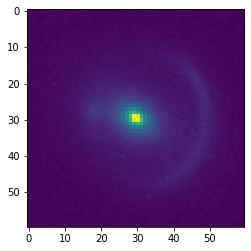

In [6]:
# note: here we're modeling the same demo system as in the paper

delta_pix = 0.065
num_pix = 60
supersample = 4

kernel = np.load('./src/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

background_rms, exp_time = 0.2, 100


# Now I make up other systems

truth = [[
    {'theta_E': 1.1, 'gamma': 1.8, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.0, 'center_y': 0.0},
    {'gamma1': -0.01, 'gamma2': 0.03}
], [
    {'R_sersic': 0.8, 'n_sersic': 2.5, 'e1': 0.09534746574143645, 'e2': 0.14849487967198177, 'center_x': 0.0, 'center_y': 0.0, 'Ie': 500.}
], [
    {'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': 0.2, 'center_y': 0.0, 'Ie': 150.}
]]

simulated = lens_sim.simulate(truth)

plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)


observed_img = simulated + np.random.normal(0, background_rms, simulated.shape) + np.random.poisson(simulated/exp_time, simulated.shape)
plt.imshow(observed_img)


In [7]:
# note in the instantiation of prob_model, the observed_img is used (though I'm not sure why)

prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [8]:
# lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=map_samples), map_estimate)[0]
# best = map_estimate[jnp.argmax(lps)][jnp.newaxis,:]
# phys_params = prob_model.bij.forward(list(map_estimate.T))

# params = phys_params
# print(len(params[0][0]))
# lens_params = params[0]

# print('shapes of img_X, img_Y:', lens_sim.img_X.shape, lens_sim.img_Y.shape)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.imshow(lens_sim.img_X[..., 0])
# ax2.imshow(lens_sim.img_Y[..., 0])



# if len(lens_sim.phys_model.lens_light) > 0:
#     lens_light_params, source_light_params = params[1], params[2]

#     # print('lens_light_params', lens_light_params)
#     # print('source_light_params', source_light_params)

# else:
#     source_light_params = params[1]



# # insert a 0 at the front allows multiple light components to be concatenated
# img_xh = jnp.zeros(lens_sim.img_X.shape)
# print(img_xh.shape)
# i = 0
# for lightModel, p in zip(lens_sim.phys_model.lens_light, lens_light_params):
#     print('lens light component, ', i)
#     # print(p)
#     # img = jnp.concatenate((img, lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)), axis=0)
#     print(lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p).shape)
#     img_xh += lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)
#     i += 1
    
# print(img_xh.shape)
# lens_light_model = img_xh[..., 0].squeeze()

# plt.imshow(lens_light_model)
# plt.colorbar()


# # I think this is the source light -- but it doesn't look right.  It's at the center

# # insert a 0 at the front allows multiple light components to be concatenated
# img_xh_s = jnp.zeros(lens_sim.img_X.shape)
# print(img_xh_s.shape)
# # img = jnp.concatenate((img, lightModel.light(beta_x, beta_y, **p)), axis=0)

# i = 0
# for lightModel, p in zip(lens_sim.phys_model.source_light, source_light_params):
#     print('source light component, ', i)
#     #print('beta x and y shapes:', beta_x.shape, beta_y.shape)
#     # print(p)
#     # img = jnp.concatenate((img, lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)), axis=0)
#     print(lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p).shape)
#     img_xh_s += lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)
#     i += 1
    
# print(img_xh_s.shape)

# # ---> this doesn't seem to agree with WS's way of doing it below
# plt.imshow(img_xh_s[..., 0].squeeze())

## Add source plane reconstruction

## Also find the light amplitude, Ie, in the case when linear inversion is used (otherwise it's one of the fitting parameters)

In [9]:
# more readable form 
def extract_params(best_params):

    mass_params = ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']
    shear_params = ['gamma1', 'gamma2']
    # if not using linear inversion -- then Ie is included
    light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y', 'Ie']
    # if using linear inversion -- then no Ie
    # light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y']

    count = 0
    for i in range(len(best_params)):
        if i==0:
            print('Lens mass params ({:d} sets):'.format(len(best_params[i])))
        elif i==1:
            print('Lens light params({:d} sets):'.format(len(best_params[i])))
        elif i==2:
            print('Source light params({:d} sets):'.format(len(best_params[i])))
        for j in range(len(best_params[i])):
            if j > 0:
                print()
            for k in range(len(best_params[i][j])):
                if i==0:
                    if j==0:
                        print('{:5s}={:6.3f}  '.format(mass_params[k], best_params[i][j][mass_params[k]]), end='')
                    elif j==1:
                        print('{:5s}={:6.3f}  '.format(shear_params[k], best_params[i][j][shear_params[k]]), end='')

                else:
                    print('{:5s}={:6.3f}  '.format(light_params[k], best_params[i][j][light_params[k]]), end='')

                count += 1
        print('\n')

# note here, we didn't use linear inversion so the brigtness, Ie, was fit for too.
# best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))   
        
# extract_params(best_params)
# print('Compared with truth: \n')


print('The truth parameters:')
extract_params(truth)
# chi2_ar = chi2_arr[-100:]
# print('min chi2: {:4.3f}'.format(chi2_arr.min()))

The truth parameters:
Lens mass params (2 sets):
theta_E= 1.100  gamma= 1.800  e1   = 0.100  e2   = 0.100  center_x= 0.000  center_y= 0.000  
gamma1=-0.010  gamma2= 0.030  

Lens light params(1 sets):
R_sersic= 0.800  n_sersic= 2.500  e1   = 0.095  e2   = 0.148  center_x= 0.000  center_y= 0.000  Ie   =500.000  

Source light params(1 sets):
R_sersic= 0.250  n_sersic= 1.500  e1   = 0.000  e2   = 0.000  center_x= 0.200  center_y= 0.000  Ie   =150.000  



Chi-square: 0.99316424


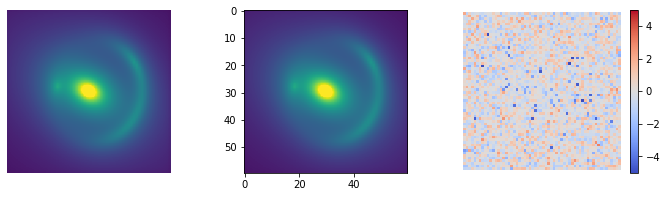

In [10]:
# compare best-fit parameters with observed image
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
# plt.colorbar()
plt.axis('off')
plt.subplot(132)
simulated = lens_sim.simulate(truth)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

plt.subplot(133)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
print('Chi-square:', np.mean((resid/err_map)**2))
plt.axis('off')
plt.colorbar()

# next use WS code to get the source plane 

# Why does the source position doesn't seem to be very close to the center of the caustic?
# Check if the source position is right? Since I'm using the truth here.

lens params: [{'theta_E': 1.1, 'gamma': 1.8, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.0, 'center_y': 0.0}, {'gamma1': -0.01, 'gamma2': 0.03}]
source light params: [{'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0.0, 'e2': 0.0, 'center_x': 0.2, 'center_y': 0.0, 'Ie': 150.0}]
(60, 60)


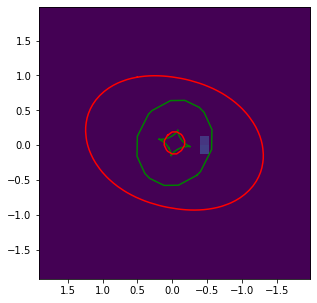

In [11]:
lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])

phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
x = lens_sim_t.simulate([[], truth[2], []])
# off = -(size-2)


print('source light params:', truth[2])


print(x.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )


scale_extent = 1.

# extent = (num_pix*delta_pix)/scale_extent, -(num_pix*delta_pix)/scale_extent, \
#          -(num_pix*delta_pix)/scale_extent, (num_pix*delta_pix)/scale_extent,

# source_img = np.rot90(np.rot90(x))
source_img = x
extent = (num_pix*delta_pix), -(num_pix*delta_pix), -(num_pix*delta_pix), (num_pix*delta_pix)


ax.imshow(source_img, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)


lens params: [{'theta_E': 1.1, 'gamma': 1.8, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.0, 'center_y': 0.0}, {'gamma1': -0.01, 'gamma2': 0.03}]
source light params: [{'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0.0, 'e2': 0.0, 'center_x': 0.2, 'center_y': 0.0, 'Ie': 150.0}]
(60, 60)


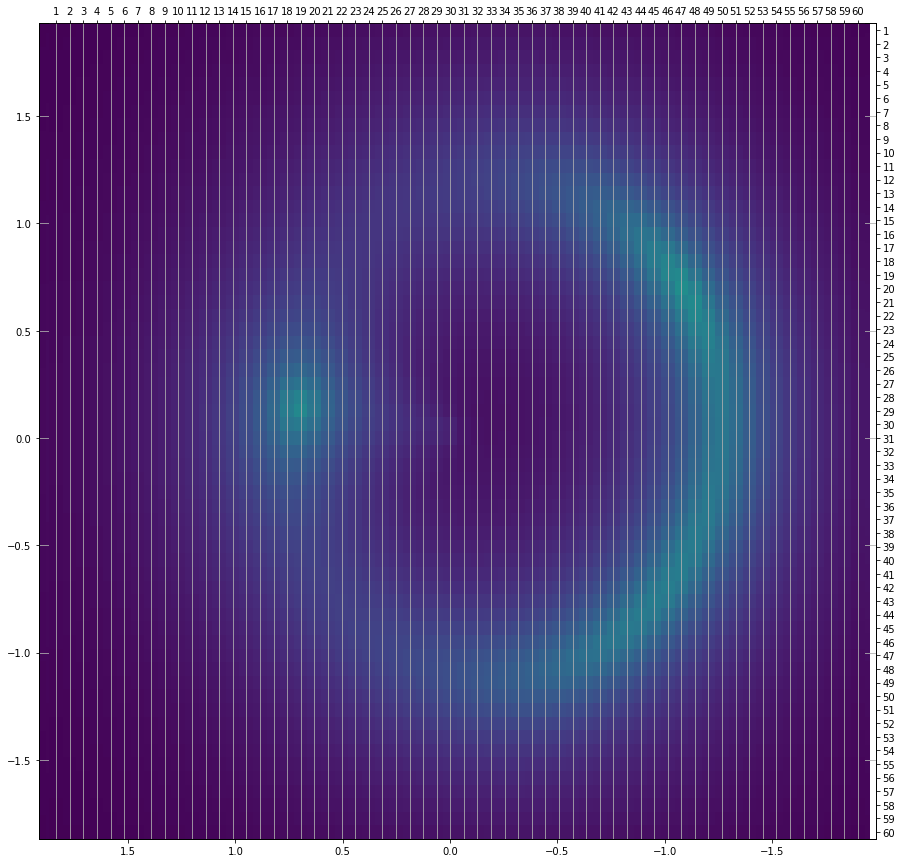

In [36]:
lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])


arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
source_img = lens_sim.simulate([[], truth[2], []])

# plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)



# phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
# sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=2, kernel=kernel)
# lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
# source_img = lens_sim_t.simulate([[], truth[2], []])
# arcs_img = lens_sim_t.simulate([truth[0], truth[1], truth[2]])

source_arcs = source_img + arcs_img

# off = -(size-2)

print('source light params:', truth[2])

print(x.shape)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )

scale_extent = 2

extent = (num_pix*delta_pix)/scale_extent, -(num_pix*delta_pix)/scale_extent, \
         -(num_pix*delta_pix)/scale_extent, (num_pix*delta_pix)/scale_extent,

# source_img = np.rot90(np.rot90(source_img))
# extent = -(num_pix*delta_pix), (num_pix*delta_pix), -(num_pix*delta_pix), (num_pix*delta_pix)


# ax.imshow(source_arcs, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)
ax.plot(truth[2][0]['center_x'], truth[2][0]['center_y'], '*', color='gray', ms=10)
ax.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20), extent=extent) #, cmap='GnBu')
ax.grid(axis='both')


ax2 = ax.twinx().twiny() #here is the trick!
ax2.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20)) #, cmap='GnBu')

# ax2.tick_params(axis='both', labelcolor='blue')
ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# Major ticks
ax2.set_xticks(np.arange(0, 60, 1))
ax2.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax2.set_xticklabels(np.arange(1, 61, 1))
ax2.set_yticklabels(np.arange(1, 61, 1))
ax2.grid(which='major', axis='both')
# ax2.set_xticks(np.linspace(0, 59, 6))
plt.show()

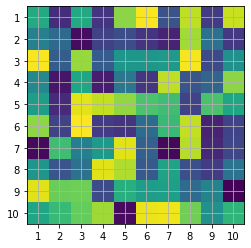

In [13]:
plt.figure()
im = plt.imshow(np.reshape(np.random.rand(100), newshape=(10,10)),
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_yticklabels(np.arange(1, 11, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

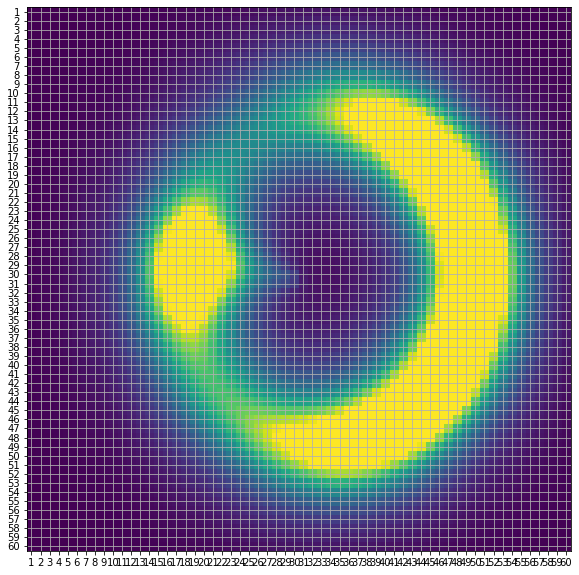

In [14]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

# ax.imshow(arcs_img)

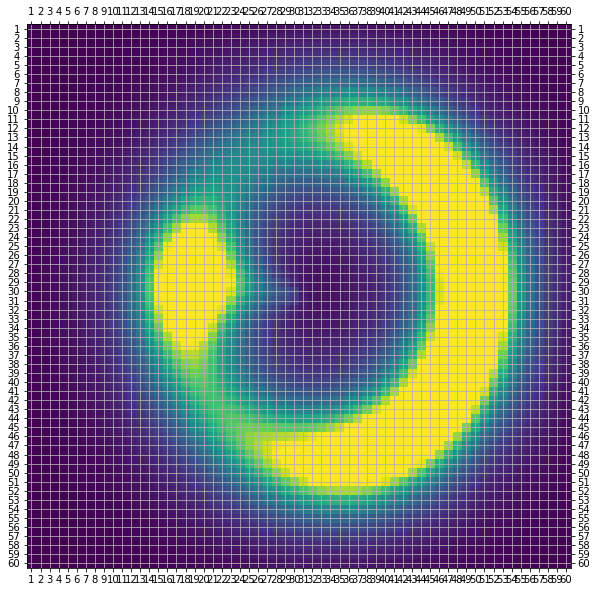

In [15]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()
ax.tick_params(top=True, labeltop=True, right=True, labelright=True)

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

ax.grid(which='major')


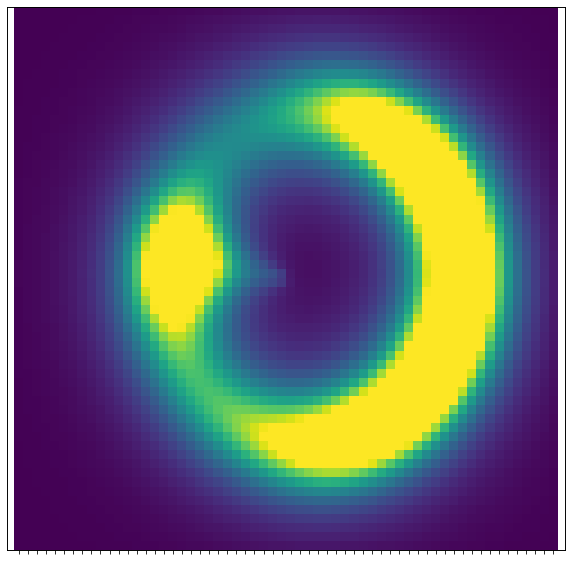

In [38]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()
ax.tick_params(left=False, labelleft=False, \
               bottom=False, labelbottom=False, \
               top=False, labeltop=False, \
               right=False, labelright=False)


# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# ax.grid(which='major')

ax2 = ax.twiny() #here is the trick!
ax2.tick_params(left=False, labelleft=False, \
               bottom=False, labelbottom=False, \
               top=False, labeltop=False, \
               right=False, labelright=False)

# ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=False, labeltop=False, right=False, labelright=False)
# # Major ticks
# # ax2.set_xticks(np.arange(0, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 1))

# # Labels for major ticks
# # ax2.set_xticklabels(np.arange(1, 61, 1))
# ax2.set_yticklabels(np.arange(1, 61, 1))
# ax2.grid(which='major', axis='x')


In [17]:
truth[2][0]

{'R_sersic': 0.25,
 'n_sersic': 1.5,
 'e1': 0.0,
 'e2': 0.0,
 'center_x': 0.2,
 'center_y': 0.0,
 'Ie': 150.0}

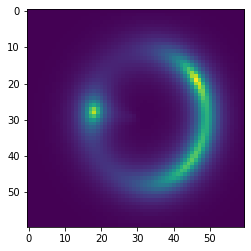

In [18]:
arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
plt.imshow(arcs_img)

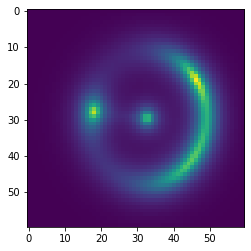

In [19]:
source_img = lens_sim.simulate([[], truth[2], []])
plt.imshow(source_img + arcs_img)

## Next: add cautic and critical curves -- reproduce one of the four archetypes

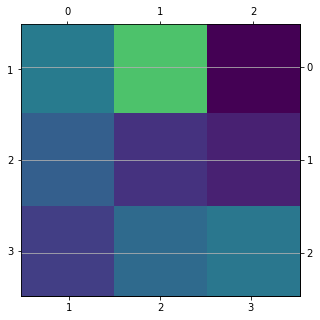

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

nx, ny = 3, 3

np.random.seed(seed=1)
img = np.reshape(np.random.rand(nx*ny), newshape=(nx, ny))

im = ax.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')

# Major ticks
ax.set_xticks(np.arange(0, nx, 1))
ax.set_yticks(np.arange(0, ny, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, nx+1, 1))
ax.set_yticklabels(np.arange(1, ny+1, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major', axis='both')


ax2 = ax.twiny().twinx() #here is the trick!

# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
ax2.set_xticks(np.arange(0, nx, 1))
ax2.set_yticks(np.arange(0, ny, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, nx+1, 1))
# ax2.set_yticklabels(np.arange(1, ny+1, 1))
ax2.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')


ax2.grid(which='major', axis='y')
# plt.show()

